# Что мы узнаем сегодня?

<img src="https://i.imgflip.com/2jvg4j.jpg" width=300 align="center">

1. [Как работать с пропусками в данных](#Пропуски-в-данных)
2. [Как работать с категориальными признаками](#Категориальные-признаки)
3. [Полезные преобразования данных](#Полезные-преобразования-данных)
4. [Инжинирим признаки](#Инжинирим-признаки)
5. [Поговорим про отбор признаков](#Отбор-признаков)
6. [KaggleInClass](#KaggleInClass)

# Пропуски в данных

Рассмотрим датасет `communities and crime`. Этот датасет содержит различные признаки, которые характеризуют район. Задача предсказать уровень преступности на 100 тысяч человек. Это задача регрессии.

In [1]:
import numpy as np
import pandas as pd

# Датасет взят отсюда: http://archive.ics.uci.edu/ml/datasets/communities+and+crime
# Загружаем датасет

x = pd.read_csv('https://raw.githubusercontent.com/ischurov/math-ml-hse-2018/master/sem05_lin_reg/communities.csv')

In [2]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Columns: 123 entries, population to ViolentCrimesPerPop
dtypes: float64(123)
memory usage: 1.9 MB


Итак, у нас 1994 района и 122 признака, `ViolentCrimesPerPop` наша таргетная переменная.

Давайте взглянем на данные:

In [3]:
# Посмотрим на данные:
x.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Видим глазами много пропусков. А как узнать сколько значений не известно?

In [4]:
x.isna().any().sum() # сколько признаков содержат неизвестные значения

23

In [5]:
x.isna().sum()[-10:] # cколько неизвестных значений содержит каждый признак

LandArea                  0
PopDens                   0
PctUsePubTrans            0
PolicCars              1675
PolicOperBudg          1675
LemasPctPolicOnPatr    1675
LemasGangUnitDeploy    1675
LemasPctOfficDrugUn       0
PolicBudgPerPop        1675
ViolentCrimesPerPop       0
dtype: int64

In [6]:
# Выведите одно число -- количество пропущенных значений
x.isna().sum().sum()

36851

**Как быть?**

<img src="https://cdn-images-1.medium.com/max/1040/1*_RA3mCS30Pr0vUxbp25Yxw.png" width=600>

**Удалить лишнее**
* Выкинуть данные с неизвестным признаком
* Выкинуть признак, если он имеет слишком мало известных значений

**Восстановить значения**

*В англоязычной терминологии это называется `imputation`.*
    
   * Для **вещественных** признаков
    * Заполнить все пропуски средним (модой, медианой) значениями признака
    * Предсказывать значение пропущенного признака с помощью линейной регрессии
   * Для **категориальных**
    * Отдельное значением типа "n/a"
    * Использовать самое частое значение признака


Хорошая идея также добавить отдельный признак `A_missing` и присваивать ему значение `1` всякий раз, когда значение признака `A` пропущено.

Более подробно можно почитать [здесь](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4).

In [7]:
# Заполняем все пропуски в данных средними значениями для каждого признака
from sklearn import preprocessing

mis_replacer = preprocessing.Imputer(strategy="mean")
x = pd.DataFrame(data=mis_replacer.fit_transform(x), columns=x.columns)

In [8]:
# Aльтернатива через pandas
# Подробнее в описании функции
x.fillna(value=0, inplace=True)

In [9]:
# Теперь можно проверить снова сколько у нас пропущенных данных
# Выведите одно число -- количество пропущенных значений
x.isna().sum().sum()

0

---

# Категориальные признаки

Для примера создадим небольшую табличку

In [10]:
import pandas as pd

# просто табличка для примера
def create_data():
    return (pd.DataFrame({'city': ['Moscow', 'London', 'London', 'Kiev',
                                   'Moscow', 'Moscow', 'Kiev','Moscow'],
                          'degree': [1,1,2,2,3,3,1,1],
                          'class':['A','B','A','A','B','B','A','A'],
                          'income':[10.2, 11.6, 8.8, 9.0, 6.6, 10.0, 9.0, 7.2]}))

data = create_data()
data

,city,degree,class,income
0,Moscow,1,A,10.2
1,London,1,B,11.6
2,London,2,A,8.8
3,Kiev,2,A,9.0
4,Moscow,3,B,6.6
5,Moscow,3,B,10.0
6,Kiev,1,A,9.0
7,Moscow,1,A,7.2


###  Как понять, что признак категориальный?

Идея - категориальные признаки те, в которых значения - строки или число уникальных значений достаточно мало.

In [11]:
# найти все признаки, в которых первое значение - строка
def find_cat(data, num_uniq=4):
    for name in data.columns:
        s = ''
        s += name
        if (type(data[name][0]) == str):
            s += ' строка,'
        if (data[name].nunique()<=num_uniq):
            s += ' мало уникальных'
        if (s!=name):
            print (s)
            
find_cat(data)

city строка, мало уникальных
degree мало уникальных
class строка, мало уникальных


### Как подавать категориальные признаки алгоритму?

Алгоритмы хотят, чтобы им на вход подавали числа, а не строки. Кроме того, большая часть алгоритмов машинного обучения тем или иным образом использует понятие расстояния между точками. Поэтому приходится подумать как же так представить категориальный признак, чтобы все заработало.

Существует как минимум *2 популярных подхода*:

1) Самый простой подход **one-hot кодирование**.
Выглядит это так

<img src="https://i.imgur.com/mtimFxh.png", width=500>

Этот способ наиболее универсален и применяется по умолчанию. Универсальность здесь означает -- возможность использования такого представления в любом алгоритме машинного обучения.

Теперь посмотрите на картинку. Если еще не стало понятно, то вот пояснение.

Суть в том, что каждое значение категориального признака порождает свой собственный признак. Далее, кодируем нулями и единицами отсутствие или наличие соответствующего признака.


In [12]:
# Очень просто с помощью pandas
# Заметим при этом, что `degree` и `income` остались неизменными.
pd.get_dummies(data)

,degree,income,city_Kiev,city_London,city_Moscow,class_A,class_B
0,1,10.2,0,0,1,1,0
1,1,11.6,0,1,0,0,1
2,2,8.8,0,1,0,1,0
3,2,9.0,1,0,0,1,0
4,3,6.6,0,0,1,0,1
5,3,10.0,0,0,1,0,1
6,1,9.0,1,0,0,1,0
7,1,7.2,0,0,1,1,0


Если хочется больше гибкости, можно попробовать для тех же целей воспользоваться `OneHotEncoder` из `sklearn.preprocessing`

2) **Группируем числовые признаки по категориальным**

Например, для каждого значения признака `city` из нашей таблички можно посчитать среднее значение `income`.

In [13]:
# функция возвращает значения нового признака
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))
def code_max(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].max()))
data = create_data()
data['city_mean_income'] = code_max(data, 'city', 'income')
data[:6]

,city,degree,class,income,city_mean_income
0,Moscow,1,A,10.2,10.2
1,London,1,B,11.6,11.6
2,London,2,A,8.8,11.6
3,Kiev,2,A,9.0,9.0
4,Moscow,3,B,6.6,10.2
5,Moscow,3,B,10.0,10.2


### Дата и время

* **Перевод в категориальные признаки**

``` python
df['dow'] = df['created'].apply(lambda x: x.date().weekday())
df['is_weekend'] = df['created'].apply(lambda x: 1 if x.date().weekday() in (5, 6) else 0)
```
Можно разбивать на рабочие дни и выходные, на конкретное время дня.

* **Проекция на окружность и использованием 2х координат**

In [14]:
def make_harmonic_features(value, period=24):
    value *= 2 * np.pi / period
    return np.cos(value), np.sin(value)

make_harmonic_features(12)

(-1.0, 1.2246467991473532e-16)

### Геоданные


<img src="http://i651.photobucket.com/albums/uu231/soopernova/latitudylongitud.gif", width=500>

In [15]:
!pip3 install reverse_geocoder

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import reverse_geocoder as revgc
revgc.search((40.74482, -73.94875))

Loading formatted geocoded file...


[OrderedDict([('lat', '40.74482'),
              ('lon', '-73.94875'),
              ('name', 'Long Island City'),
              ('admin1', 'New York'),
              ('admin2', 'Queens County'),
              ('cc', 'US')])]

---

# Полезные преобразования данных

Иногда числовые значения признаков хорошо бы привести к другим значениям с помощью преобразований. Очень часто это может улучшить результаты некоторых алгоритмов. Такие алгоритмы, как правило, делают некоторые предположения о характере данных или же опираются на расстояния между элементами выборки.


**Популярные преобразования**

(1) **Z-score**
$$\large z(x) = \frac{x - \mu}{\sigma}$$

* Полезно, если существенно расстояние между точками (например в knn)
* Это преобразование линейное, оно не меняет распределение данных

In [17]:
# Есть в sklearn
from sklearn.preprocessing import StandardScaler

In [18]:
# Обратим внимание на значение 100
data = np.array([1, 1, 0, -1, 2, 3, -2, 4, 100], dtype=np.float32).reshape(-1,1)
StandardScaler().fit_transform(data)

array([[-0.3529866 ],
       [-0.3529866 ],
       [-0.3850763 ],
       [-0.417166  ],
       [-0.32089692],
       [-0.28880724],
       [-0.44925568],
       [-0.25671753],
       [ 2.8238928 ]], dtype=float32)

In [19]:
# Это то же самое, что сделать это руками:
(data - data.mean()) / data.std()

array([[-0.3529866 ],
       [-0.3529866 ],
       [-0.3850763 ],
       [-0.417166  ],
       [-0.32089692],
       [-0.28880724],
       [-0.44925568],
       [-0.25671753],
       [ 2.8238928 ]], dtype=float32)

   ---
   (2) **MinMax Scaling**
    
Другой достаточно популярный вариант – MinMax Scaling, который переносит все точки на заданный отрезок (обычно (0, 1))
$$ \large X_{norm}=\frac{X-X_{min}}{X_{max}-X_{min}} $$

* Полезно, если хочется оценить влияние признака по весам в линейной регрессии
* Можно перенести значение признака в интервал (0, 255) для визуализации

В целом, оба варианта часто взаимозаменяемы.

In [20]:
# Демонстрация
from sklearn.preprocessing import MinMaxScaler
MinMaxScaler().fit_transform(data)

array([[0.02941177],
       [0.02941177],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.0000001 ]], dtype=float32)

In [21]:
(data - data.min()) / (data.max() - data.min())

array([[0.02941176],
       [0.02941176],
       [0.01960784],
       [0.00980392],
       [0.03921569],
       [0.04901961],
       [0.        ],
       [0.05882353],
       [1.        ]], dtype=float32)

(3) **Логарифмирование**

~~(как способ бороться с тяжелыми хвостами)~~

<img src="http://edgewatertech.files.wordpress.com/2008/07/long-tail.png" width=300 align="left">

* Существует ряд преобразований, которые позволяют из распределения с "тяжелым хвостом" (в английском варианте long tail) сделать распределение похожее на нормальное. 

* Нормальное распределение нравится многим алгоритмам машинного обучения и такое преобразование иногда может улучшить ситуацию.


In [22]:
%pylab inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


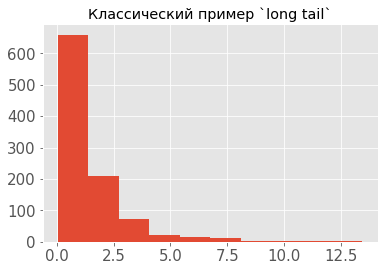

In [23]:
from scipy.stats import lognorm

# сгенерируем себе выборку

data = lognorm(s=1).rvs(1000)
plt.hist(data)
plt.title("Классический пример `long tail`")
plt.show()

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


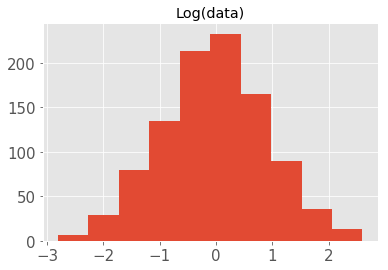

In [24]:
# А вот так выглядят данные после логарифмирования

plt.hist(np.log(data))
plt.title("Log(data)")
plt.show()

---

# Инжинирим признаки

<img src="https://i.imgflip.com/2jvgeb.jpg" width=300 align="center">


Как помочь нашей модели найти полезные зависимости в данных?

Можно условно поделить генерацию признаков на **две части**:
 1. Создание признаков **на основе знаний** и житейского опыта
 2. Создание всяких разных **случайных взаимодействий** признаков
 

### Полиномиальные признаки

Почему готовить новые признаки это хорошо?

**XOR проблема**

XOR – это "исключающее ИЛИ", булева функция со следующей таблицей истинности:

<img src="https://habrastorage.org/storage2/9af/1de/e09/9af1dee09d4d36ff0b15bdb4aae19e3b.png" width=400 align="center">

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


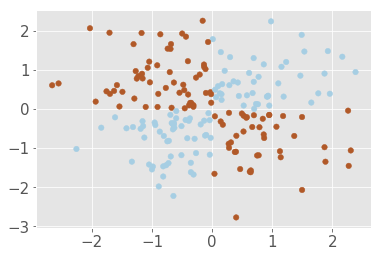

In [25]:
# порождаем данные
rng = np.random.RandomState(0)
X = rng.randn(200, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
plt.show()

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
# Функция рисует плоскость согласно предсказаниям классификатора clf
def plot_boundary(clf, X, y, plot_title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 50),
                     np.linspace(-3, 3, 50))
    clf.fit(X, y)
    # plot the decision function for each datapoint on the grid
    Z = clf.predict_proba(np.vstack((xx.ravel(), yy.ravel())).T)[:, 1]
    Z = Z.reshape(xx.shape)

    image = plt.imshow(Z, interpolation='nearest',
                           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                           aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)
    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                               linetypes='--')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis([-3, 3, -3, 3])
    plt.colorbar(image)
    plt.title(plot_title, fontsize=12);

In [28]:
from sklearn.linear_model import LogisticRegression

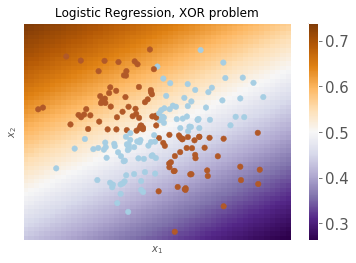

In [29]:
# Применяем логистическую регрессию к нашим данным
# И видим, что линейная модель не способна разделить точки правильно
plot_boundary(LogisticRegression(), X, y, "Logistic Regression, XOR problem")

### Что мы делаем?
Добавляем полиномиальных признаков!

Т.е. получаем несколько признаков из данных путем их возведения в степень и перемножения между собой.

**Пример с двумерными данными, degree=2**

$$\Large (a, b) \rightarrow (1, a, b, a^2, ab, b^2)$$

Удобно, что sklearn уже умеет генерировать полиномиальные признаки для нас

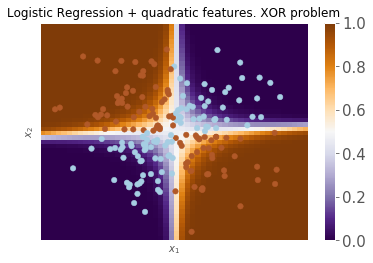

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

logit_pipe = Pipeline([('poly', PolynomialFeatures(degree=2)), 
                       ('logit', LogisticRegression())])
plot_boundary(logit_pipe, X, y,
        "Logistic Regression + quadratic features. XOR problem")

# Проблема решается!

### Применение житейской смекалки
для создания признаков

<img src="http://memesmix.net/media/created/kudgoj.jpg", width=300>

Есть количество комнат и стоимость аренды

Выделяем новый признак -- стоимость аренды одной комнаты:
```python
rooms = df["bedrooms"]
df["price_per_bedroom"] = df["price"] / rooms
```

# Отбор признаков

1. Чисто статистическими методами
2. С использованием моделей
3. Перебором

### Статистические методы

#### Отсечение низко вариативных признаков
<img src="https://s3.amazonaws.com/ceblog/wp-content/uploads/2016/05/03115329/high-low-variance.png", width=500>

Т.е. если признак очень мало изменяет свое значение среди всех точек выборки, то вероятно, он не очень полезен.

In [31]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
x_data_generated, y_data_generated = make_classification()
x_data_generated.shape

(100, 20)

In [32]:
VarianceThreshold(.7).fit_transform(x_data_generated).shape

(100, 19)

In [33]:
VarianceThreshold(.8).fit_transform(x_data_generated).shape

(100, 17)

In [34]:
VarianceThreshold(.9).fit_transform(x_data_generated).shape

(100, 11)

#### Отбор k лучших с помощью ANOVA
 Мы так и не узнаем сегодня что такое ANOVA, но уже можем это использовать
 
<img src="https://www.questionpro.com/blog/wp-content/uploads/2016/03/rsz_anova-800x444.jpg", width=500>

In [35]:
from sklearn.feature_selection import SelectKBest, f_classif

# Выбираем 5 лучших фичей
x_data_kbest = SelectKBest(f_classif, k=5).fit_transform(x_data_generated, y_data_generated)

# Выбираем фичи по граничному значению дисперсии данных
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Результат для исходных данных
cross_val_score(LogisticRegression(), x_data_generated, y_data_generated, scoring='accuracy').mean()

0.7506127450980392

In [37]:
# Для отбора по вариативности
cross_val_score(LogisticRegression(), x_data_varth, y_data_generated, scoring='accuracy').mean()

0.8100490196078431

In [38]:
# Для отбора по ANOVA
cross_val_score(LogisticRegression(), x_data_kbest, y_data_generated, scoring='accuracy').mean()

0.8511029411764706

### Использование моделей
Для отбора признаков чаще всего используют L1 регуляризацию с линейной/логистической регрессией или случайный лес (о котором вы пока не знаете)

In [39]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

# Еще раз покажем результат с простой моделью и исходными данными

lr = LogisticRegression()
print(cross_val_score(lr, x_data_generated, y_data_generated, scoring='accuracy').mean())

0.7506127450980392


In [40]:
# Теперь произведем отбор признаков с помощью нашей логистической регрессии,
# Отобранные признаки подадим далее в саму логистическую регрессию

pipe = make_pipeline(SelectFromModel(estimator=LogisticRegression(penalty='l1',)), LogisticRegression())
print(cross_val_score(pipe, x_data_generated, y_data_generated, scoring='accuracy').mean())

0.7420343137254902


In [41]:
def accuracy(y, y_pred):
    return np.sum(y == y_pred) / len(y)

print(accuracy(np.array[0, 0, 1]))


TypeError: 'builtin_function_or_method' object is not subscriptable

### Перебор признаков

* **Exhaustive Feature Selection** - полный перебор всех возможных сочетаний и подмножеств признаков. Очень долго, но точно найдет нужное.

* **SequentialFeatureSelector** - найдет лучшее подмножество из k признаков.

In [42]:
# устанавливаем mlxtend:
!pip3 install mlxtend  

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [43]:
from mlxtend.feature_selection import SequentialFeatureSelector

selector = SequentialFeatureSelector(LogisticRegression(), scoring='accuracy',
                                     verbose=2, k_features=3, forward=False, n_jobs=-1)

selector.fit(x_data_generated, y_data_generated)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.1s finished

[2018-11-03 00:05:41] Features: 19/3 -- score: 0.8200000000000001[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.1s finished

[2018-11-03 00:05:41] Features: 18/3 -- score: 0.8400000000000001[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.1s finished

[2018-11-03 00:05:42] Features: 17/3 -- score: 0.86[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:    0.1s finished

[2018-11-03 00:05:42] Features: 16/3 -- score: 0.86[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.1s finished

[2018-11-03 00:05:43] Features: 15/3 -- score: 0.86[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.1s finished

[2018-11-03 00:05:43] Features: 14/3 -- score: 0.8800000000000001[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0

SequentialFeatureSelector(clone_estimator=True, cv=5,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
             floating=False, forward=False, k_features=3, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='accuracy', verbose=2)

Итак, удалось достигнуть accuracy=0.99, что супер круто! Но это, конечно, синтетическая задачка. С реальными данными все намного сложнее.

# KaggleInClass

Начнем решать соревнование на платформе `Kaggle` (пока только `InClass`)

Ссылка на соревнование: https://www.kaggle.com/c/best-home

In [1]:
<YOUR TURN>

SyntaxError: invalid syntax (<ipython-input-1-8575a6c2e31f>, line 1)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import reverse_geocoder as revgc
from sklearn.feature_selection import SelectKBest, f_classif
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))
def code_max(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].max()))
def code_min(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].min()))
df = pd.read_csv("all/train.csv")
#print(df['bedrooms'].sum().sum())
df = df.drop(df[pd.isna(df.TARGET)].index)
df['count_features'] = df['features'].apply(lambda x: len(eval(x)))
df['year'] = df['created'].str[:4].astype(int)
df['month'] = df['created'].str[5:7].astype(int)
df['day'] = df['created'].str[8:10].astype(int)
df['hour'] = df['created'].str[11:13].astype(int)
df['minute'] = df['created'].str[14:16].astype(int)
df['second'] = df['created'].str[17:19].astype(int)
y = df["TARGET"].values
X =  df.drop(['Id', 'photos', 'display_address', 'listing_id', 'building_id', 'manager_id', 'created', 'TARGET','features'], axis=1)
print()
mis_replacer = preprocessing.Imputer(strategy="mean") 
X = pd.DataFrame(data=mis_replacer.fit_transform(X), columns=X.columns)
rooms = X["bedrooms"]
X["price_per_bedroom"] = X["price"] / (rooms + 1)
rooms = X["bathrooms"]
X["price_per_bathroom"] = X["price"] / (rooms + 1)

#cites = []
#for i in range(len(X)):
#    some = revgc.search((X['latitude'][i], X['longitude'][i]))
#    print(some[0]['name'])
#    cites.append(some[0]['name'])
#X['city'] = cites
#X['city_mean_price'] = code_mean(X, 'city', 'price')
#X['max_city_price'] = code_max(X, 'city', 'price')
#X['min_city_price'] = code_min(X, 'city', 'price')
#X = X.drop(['city'], axis=1)
reg = LogisticRegression()
reg.fit(X, y)
print(cross_val_score(LogisticRegression(), X, y, scoring='accuracy').mean())
df = pd.read_csv("all/test.csv")
df['count_features'] = df['features'].apply(lambda x: len(eval(x)))
df['year'] = df['created'].str[:4].astype(int)
df['month'] = df['created'].str[5:7].astype(int)
df['day'] = df['created'].str[8:10].astype(int)
df['hour'] = df['created'].str[11:13].astype(int)
df['minute'] = df['created'].str[14:16].astype(int)
df['second'] = df['created'].str[17:19].astype(int)
X =  df.drop(['Id', 'photos', 'listing_id', 'display_address', 'building_id', 'manager_id', 'created', 'features'], axis=1)
mis_replacer = preprocessing.Imputer(strategy="mean")
X = pd.DataFrame(data=mis_replacer.fit_transform(X), columns=X.columns)
rooms = X["bedrooms"]
X["price_per_bedroom"] = X["price"] / (rooms + 1)
rooms = X["bathrooms"]
X["price_per_bathroom"] = X["price"] / (rooms + 1)
#cites = []
#for i in range(len(X)):
#    some = revgc.search((X['latitude'][i], X['longitude'][i]))
#    print(some[0]['name'])
#    cites.append(some[0]['name'])
#X['city'] = cites
#X['city_mean_price'] = code_mean(X, 'city', 'price')
#X['max_city_price'] = code_max(X, 'city', 'price')
#X['min_city_price'] = code_min(X, 'city', 'price')
#X = X.drop(['city'], axis=1)
y = reg.predict(X)
df['TARGET'] = y
df[['TARGET', 'Id']].to_csv('ans.csv', index=None)


0.6910899025182663
